In [109]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [110]:
dfs = []
for i in range(1,5):
    path = '/kaggle/input/unsw-nb15/UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
combined_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

In [111]:
combined_data.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [112]:
dataset_columns = pd.read_csv('/kaggle/input/unsw-nb15/NUSW-NB15_features.csv',encoding='ISO-8859-1')
dataset_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   No.          49 non-null     int64 
 1   Name         49 non-null     object
 2   Type         49 non-null     object
 3   Description  49 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


In [113]:
combined_data.columns = dataset_columns['Name']
combined_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [114]:
combined_data['Label'].value_counts()

Label
0    2218764
1     321283
Name: count, dtype: int64

In [115]:
combined_data['attack_cat'].isnull().sum()

2218764

# handling missing values

In [116]:
combined_data['attack_cat'] = combined_data['attack_cat'].fillna(value='normal').apply(lambda x: x.strip().lower())

In [117]:
combined_data['attack_cat'].value_counts()

attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             1795
shellcode            1511
backdoors             534
worms                 174
Name: count, dtype: int64

In [118]:
combined_data['attack_cat'] = combined_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
combined_data['attack_cat'].value_counts()

attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: count, dtype: int64

In [119]:
combined_data.isnull().sum()


Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
Sload                     0
Dload                     0
Spkts                     0
Dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
Sjit                      0
Djit                      0
Stime                     0
Ltime                     0
Sintpkt                   0
Dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [120]:
combined_data['ct_flw_http_mthd'] = combined_data['ct_flw_http_mthd'].fillna(value=0)
combined_data['is_ftp_login'] = combined_data['is_ftp_login'].fillna(value=0)


In [121]:
combined_data['is_ftp_login'] = np.where(combined_data['is_ftp_login']>1, 1, combined_data['is_ftp_login'])
combined_data['is_ftp_login'].value_counts()

is_ftp_login
0.0    2496472
1.0      43575
Name: count, dtype: int64

In [122]:
combined_data['service'].value_counts()

service
-           1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: count, dtype: int64

In [123]:
#combined_data['service'] = combined_data['servie'].replace(to_replace='-', value='None')
combined_data['service'] = combined_data['service'].apply(lambda x:"None" if x=='-' else x)
combined_data['service'].value_counts()

service
None        1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: count, dtype: int64

In [124]:
combined_data['ct_ftp_cmd'] = combined_data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)
combined_data['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3])

In [125]:
combined_data[['service','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','attack_cat','Label']]

Name,service,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,attack_cat,Label
0,dns,0.0,0.0,0,normal,0
1,None,0.0,0.0,0,normal,0
2,dns,0.0,0.0,0,normal,0
3,dns,0.0,0.0,0,normal,0
4,dns,0.0,0.0,0,normal,0
...,...,...,...,...,...,...
2540042,ftp-data,0.0,0.0,0,normal,0
2540043,ftp,0.0,1.0,2,normal,0
2540044,ftp,0.0,1.0,2,normal,0
2540045,http,2.0,0.0,0,normal,0


# dropping irrelevent columns

In [126]:
combined_data.drop(columns=['srcip','sport','dstip','dsport','Label'],inplace=True)
combined_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 44 columns):
 #   Column            Dtype  
---  ------            -----  
 0   proto             object 
 1   state             object 
 2   dur               float64
 3   sbytes            int64  
 4   dbytes            int64  
 5   sttl              int64  
 6   dttl              int64  
 7   sloss             int64  
 8   dloss             int64  
 9   service           object 
 10  Sload             float64
 11  Dload             float64
 12  Spkts             int64  
 13  Dpkts             int64  
 14  swin              int64  
 15  dwin              int64  
 16  stcpb             int64  
 17  dtcpb             int64  
 18  smeansz           int64  
 19  dmeansz           int64  
 20  trans_depth       int64  
 21  res_bdy_len       int64  
 22  Sjit              float64
 23  Djit              float64
 24  Stime             int64  
 25  Ltime             int64  
 26  Sintpkt       

In [127]:
combined_data.shape

(2540047, 44)

# data splitting

In [128]:
train, test = train_test_split(combined_data,test_size=0.2,random_state=16)
train, val = train_test_split(train,test_size=0.2,random_state=16)
print(train.shape)
print(test.shape)

(1625629, 44)
(508010, 44)


# dropping target from training set and adding in testing set

In [129]:
x_train, y_train = train.drop(columns=['attack_cat']), train[['attack_cat']]
x_test, y_test = test.drop(columns=['attack_cat']), test[['attack_cat']]
x_val, y_val = val.drop(columns=['attack_cat']), val[['attack_cat']]

In [130]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

# features correlation graph

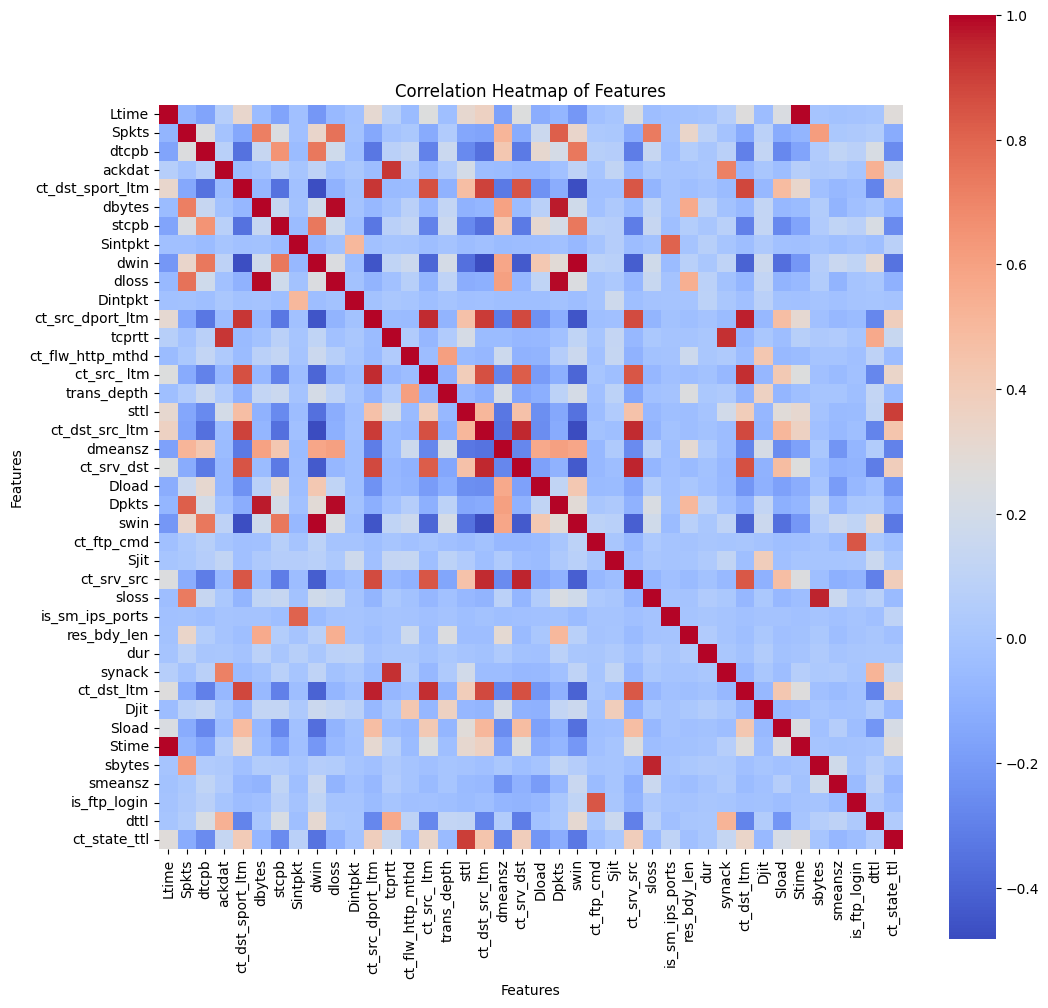

In [131]:
correlation_matrix = train[num_col].corr()


plt.figure(figsize=(12, 12))  


sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap of Features')

# Rotate x-axis labels for better readability with many features
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

# samples distributions

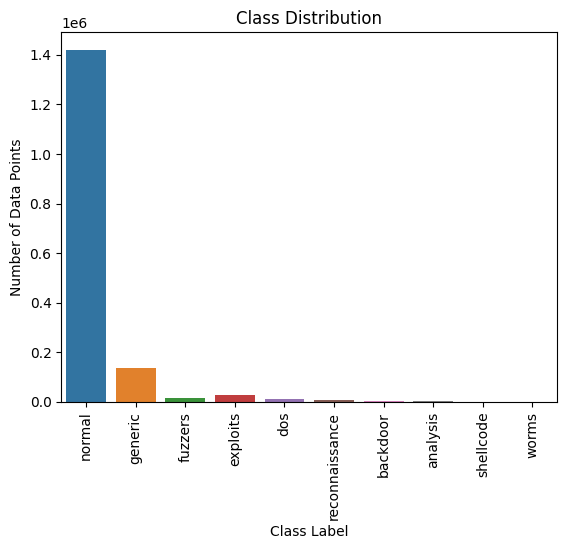

In [132]:
labels = train['attack_cat']

# Create a count plot with Seaborn
sns.countplot(x=labels)

# Add labels and title
plt.xlabel('Class Label')
plt.ylabel('Number of Data Points')
plt.title('Class Distribution')

# Rotate x-axis labels for better readability if there are many classes
plt.xticks(rotation=90)

# Show the plot
plt.show()

# label encoding

In [133]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_col])
x_train[num_col] = scaler.transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])
x_val[num_col] = scaler.transform(x_val[num_col])

In [134]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), cat_col)], remainder='passthrough')
x_train = np.array(ct.fit_transform(x_train))
x_test = np.array(ct.transform(x_test))
x_val = np.array(ct.transform(x_val))

In [135]:
attacks = y_train['attack_cat'].unique()
attacks

array(['normal', 'generic', 'fuzzers', 'exploits', 'dos',
       'reconnaissance', 'backdoor', 'analysis', 'shellcode', 'worms'],
      dtype=object)

In [136]:
# Get unique elements and their counts
unique_values, counts = np.unique(y_train, return_counts=True)

# Print the unique values and their corresponding counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: analysis, Count: 1716
Value: backdoor, Count: 1499
Value: dos, Count: 10454
Value: exploits, Count: 28640
Value: fuzzers, Count: 15494
Value: generic, Count: 137574
Value: normal, Count: 1420187
Value: reconnaissance, Count: 8985
Value: shellcode, Count: 979
Value: worms, Count: 101


In [137]:
# Get unique elements and their counts
unique_values, counts = np.unique(y_test, return_counts=True)

# Print the unique values and their corresponding counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: analysis, Count: 544
Value: backdoor, Count: 470
Value: dos, Count: 3288
Value: exploits, Count: 8709
Value: fuzzers, Count: 4928
Value: generic, Count: 43187
Value: normal, Count: 443714
Value: reconnaissance, Count: 2813
Value: shellcode, Count: 320
Value: worms, Count: 37


In [138]:
ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(categories=[attacks],sparse=False), ['attack_cat'])], remainder='passthrough')
y_train = np.array(ct1.fit_transform(y_train))
y_test = np.array(ct1.transform(y_test))
y_val = np.array(ct1.transform(y_val))

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout

In [140]:
# Define model parameters
n_features = x_train.shape[1]  # Number of features from training data

# Define the model
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(n_features,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# First LSTM block
model.add(LSTM(units=16, return_sequences=True))
#model.add(Dropout(0.2))  # Added dropout after LSTM

# Second convolutional block
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second LSTM block
model.add(LSTM(units=32, return_sequences=True))
#model.add(Dropout(0.2))  # Added dropout after LSTM

# Third convolutional block
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third LSTM block
model.add(LSTM(units=64))
#model.add(Dropout(0.2))  # Added dropout after LSTM

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Adjusted dropout rate for dense layer

model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ (None, 204, 16)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 102, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 102, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 102, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 100, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 46, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,618 (236.79 KB)

 Trainable params: 60,394 (235.91 KB)

 Non-trainable params: 224 (896.00 B)

# model training

In [142]:
history = model.fit(x_train, y_train, epochs=5, batch_size=256,validation_data=(x_val,y_val))



Epoch 1/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 105s 16ms/step - accuracy: 0.9733 - loss: 0.0686 - precision_12: 0.9900 - recall_12: 0.9614 - val_accuracy: 0.9764 - val_loss: 0.0595 - val_precision_12: 0.9898 - val_recall_12: 0.9669
Epoch 2/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 103s 16ms/step - accuracy: 0.9763 - loss: 0.0603 - precision_12: 0.9896 - recall_12: 0.9667 - val_accuracy: 0.9769 - val_loss: 0.0585 - val_precision_12: 0.9907 - val_recall_12: 0.9670
Epoch 3/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 103s 16ms/step - accuracy: 0.9773 - loss: 0.0579 - precision_12: 0.9900 - recall_12: 0.9680 - val_accuracy: 0.9776 - val_loss: 0.0562 - val_precision_12: 0.9911 - val_recall_12: 0.9677
Epoch 4/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 103s 16ms/step - accuracy: 0.9775 - loss: 0.0569 - precision_12: 0.9904 - recall_12: 0.9682 - val_accuracy: 0.9780 - val_loss: 0.0543 - val_precision_12: 0.9896 - val_recall_12: 0.9698
Epoch 5/5
6351/6351 ━━━━━━━━━━━━━━━━━━━━ 103s 16ms/step - accuracy: 0.9780 - loss: 0.0549 - prec

# model testing

In [143]:
 #Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - accuracy: 0.9780 - loss: 0.0541 - precision_12: 0.9899 - recall_12: 0.9695
Test Loss: 0.053619496524333954
Test Accuracy: 0.9782720804214478
Test Precision: 0.9901148080825806
Test Recall: 0.9700478315353394


# F1-score

In [144]:
from sklearn.metrics import f1_score
y_pred = model.predict(x_test) 
# Convertir les prédictions en labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculer le F1-score
f1 = f1_score(y_test.argmax(axis=1), y_pred_labels, average='weighted')

print("F1-Score:", f1)

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step
F1-Score: 0.9739351769932557


# training-progress

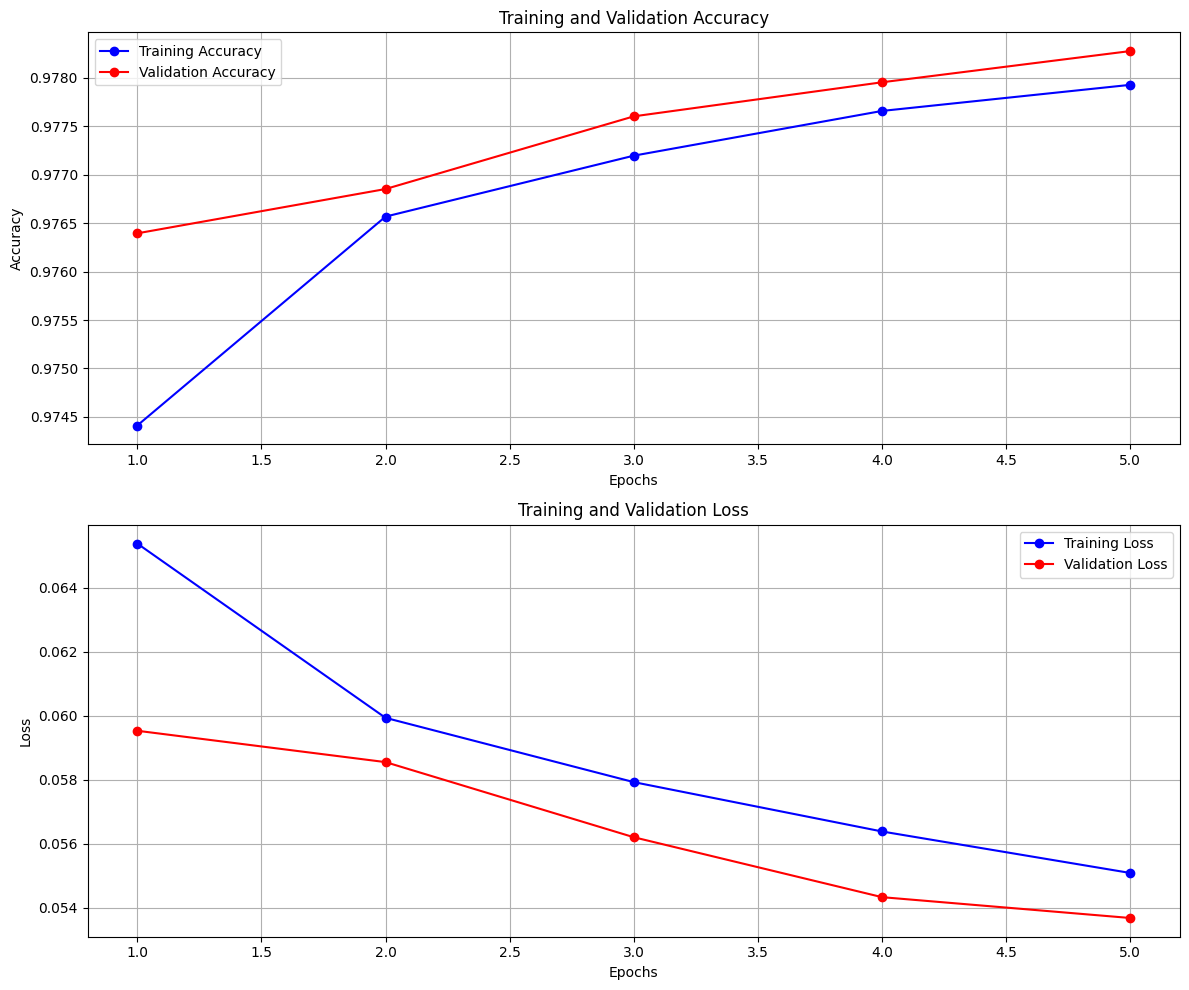

In [145]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Define epochs
epochs = range(1, len(train_accuracy) + 1)

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot training and validation accuracy
ax1.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid()

# Plot training and validation loss
ax2.plot(epochs, train_loss, 'bo-', label='Training Loss')
ax2.plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid()

# Show the plots
plt.tight_layout()
plt.show()


# confusion matrix 

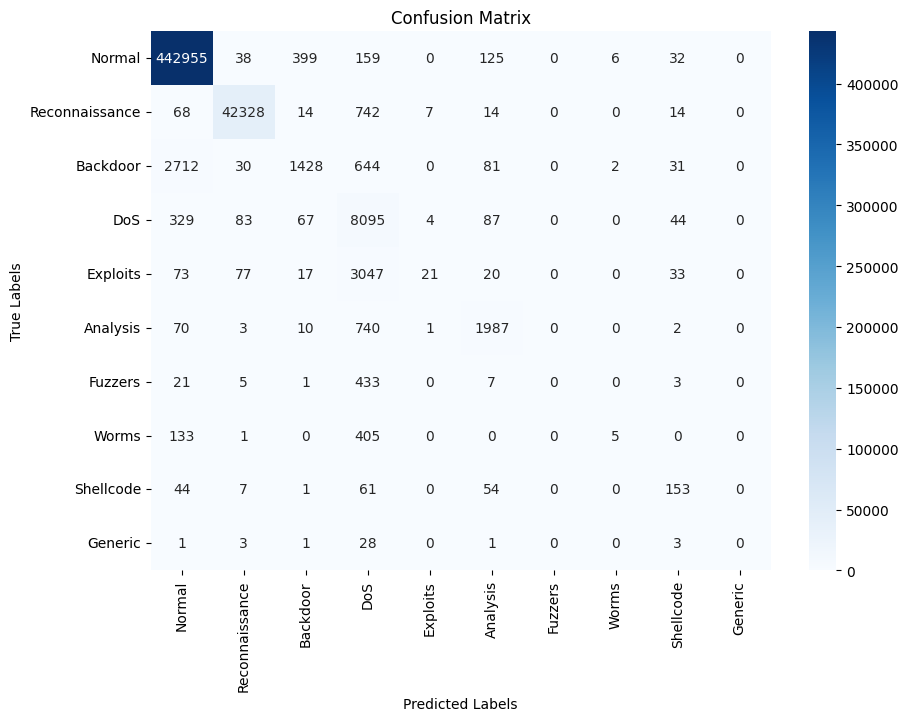

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels = ['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic']


y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to class indices if needed

# Step 2: Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC cruves

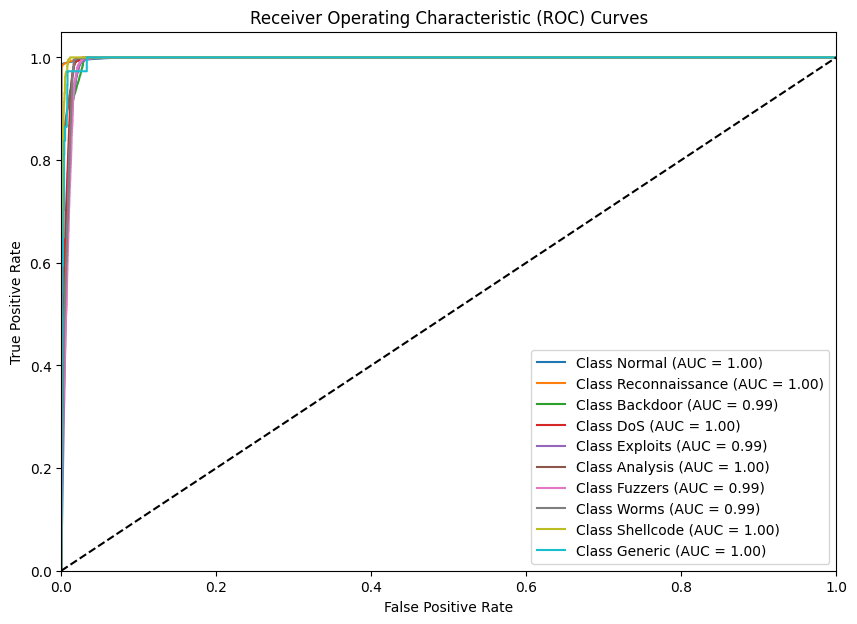

In [149]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc

labels = ['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic']
n_classes = len(labels)


y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to class indices
# Step 4: Binarize the output labels
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_pred_bin = y_pred  # Assuming y_pred is already in probability format for multi-class

# Step 5: Compute ROC and AUC for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()